In [1]:
import pandas as pd
import numpy as np
import torch
import torch.nn as nn
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score
from collections import Counter

# Штуки с данными

In [2]:
class DataLoader:
    
    def __init__(self, data, target, batch_size=256):
        self.data = data
        self.target = target
        self.batch_size = batch_size

    def next(self):
        m, _ = self.data.shape
        rand_index = np.random.choice(m, size=m)
        X, y = self.data[rand_index], self.target[rand_index]
        pos = 0
        while pos < m:
            X_batch, y_batch = X[pos:pos+self.batch_size], y[pos:pos+self.batch_size]
            yield (torch.FloatTensor(X_batch), torch.LongTensor(y_batch))
            pos += self.batch_size

    def __call__(self):
        return self.next()


In [3]:
X = pd.read_csv('mnist_data.csv').values[:, 1:]
y = pd.read_csv('mnist_target.csv').values[:, 1]

In [4]:
X = X / 255

In [5]:
X_train_val, X_test, y_train_val, y_test = train_test_split(X, y, test_size=0.2, stratify=y, random_state=42)
X_train, X_val, y_train, y_val = train_test_split(X_train_val, y_train_val, test_size=0.2, stratify=y_train_val, random_state=42)

# Сетка

In [6]:
class Model(nn.Module):
    
    def __init__(self, inp_dim, out_dim=10):
        super().__init__()
        
        lin1 = nn.Linear(inp_dim, 256)
        torch.nn.init.xavier_normal_(lin1.weight)
        
        lin2 = nn.Linear(256, out_dim)
        torch.nn.init.xavier_normal_(lin1.weight)
        
        self.layers = nn.Sequential(lin1, nn.ReLU(), lin2)
    
    def forward(self, inp):
        return self.layers(inp)

# Классификатор

In [7]:
class Classifier:
    
    def __init__(self, inp_dim, out_dim=10):
        self.model = Model(inp_dim, out_dim)
        self.optimizer = torch.optim.Adam(self.model.parameters(), lr=1e-4)
        self.loss_function = nn.CrossEntropyLoss()
    
    def predict(self, X):
        if not torch.is_tensor(X):
            X = torch.tensor(X).float()   
        return torch.argmax(self.model(X), axis=1)
    
    def fit(self, X_train, y_train, X_val=None, y_val=None, num_epochs=50):         
        dataloader = DataLoader(X_train, y_train)
        losses = []
        accuracies = []
        for epoch in range(num_epochs):
            loss_sum = 0
            for data in dataloader():
                inputs, targets = data
                outputs = self.model(inputs)
                loss = self.loss_function(outputs, targets)
                loss_sum += loss.detach()
                
                self.optimizer.zero_grad()
                loss.backward()
                self.optimizer.step()
                
            if X_val is not None:
                acc = accuracy_score(y_true=y_val, y_pred=self.predict(X_val))
                print(f'Epoch: [{epoch+1}/{num_epochs}], loss: {loss_sum}, acc: {acc}')
                accuracies.append(acc)
            else:
                print(f'Epoch: [{epoch+1}/{num_epochs}], loss: {loss_sum}')
            losses.append(loss_sum)
    
        plt.figure(figsize=(7, 7))
        plt.plot(list(range(1, num_epochs + 1)), losses)
        plt.title('Loss function value')
        plt.show()
        
        plt.figure(figsize=(7, 7))
        plt.plot(list(range(1, num_epochs + 1)), accuracies)
        plt.title('Accuracy')
        plt.show()
    
    def fast_adversarial(self, dig, n=784, n_classes=10, eta=0.01, iters=10):
        y = torch.LongTensor([dig])
        x = torch.tensor(np.random.normal(loc=0, scale=0.01, size=n),
                         requires_grad=True, dtype=torch.float)
        for _ in range(iters):
            loss = self.loss_function(self.model(x).unsqueeze(0), y)
            self.model.zero_grad()
            loss.backward()       
            x = torch.clamp(x - eta * x.grad.sign(), 0, 1).clone().detach().requires_grad_(True)
        return x
            

# Обучение

Epoch: [1/50], loss: 277.2572326660156, acc: 0.8364285714285714
Epoch: [2/50], loss: 120.50691223144531, acc: 0.8792857142857143
Epoch: [3/50], loss: 81.52206420898438, acc: 0.8973214285714286
Epoch: [4/50], loss: 66.60122680664062, acc: 0.90625
Epoch: [5/50], loss: 58.57162094116211, acc: 0.9130357142857143
Epoch: [6/50], loss: 54.49159240722656, acc: 0.9191964285714286
Epoch: [7/50], loss: 49.950592041015625, acc: 0.9234821428571428
Epoch: [8/50], loss: 46.629730224609375, acc: 0.928125
Epoch: [9/50], loss: 45.050621032714844, acc: 0.9311607142857142
Epoch: [10/50], loss: 40.75532150268555, acc: 0.9346428571428571
Epoch: [11/50], loss: 39.666831970214844, acc: 0.9351785714285714
Epoch: [12/50], loss: 38.453128814697266, acc: 0.9383928571428571
Epoch: [13/50], loss: 37.50762939453125, acc: 0.9414285714285714
Epoch: [14/50], loss: 34.9968147277832, acc: 0.941875
Epoch: [15/50], loss: 33.88245391845703, acc: 0.9442857142857143
Epoch: [16/50], loss: 32.13374328613281, acc: 0.946071428571

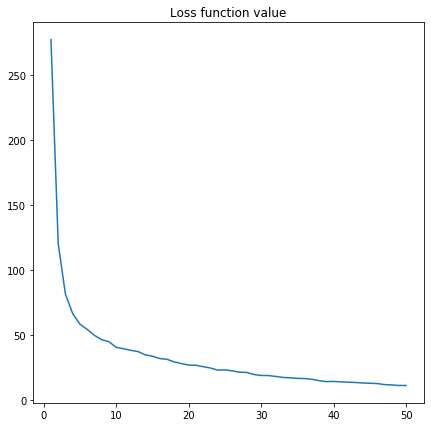

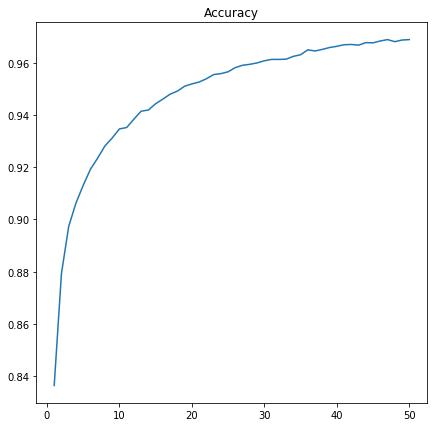

In [8]:
classifier = Classifier(X_train.shape[1])
classifier.fit(X_train, y_train, X_val, y_val, 50)

# Результаты Adversarial Attack

In [9]:
example = classifier.fast_adversarial(8, eta=0.1, iters=5)

In [10]:
alpha = 0.5

In [11]:
X_spoiled = torch.max(torch.FloatTensor(X_test)*(1-alpha), alpha*example)

In [12]:
print(f'Частоты истинных классов: {Counter(np.array(y_test, dtype=int))}')
print('***********************')
print('До шума: ')
y_pred = classifier.predict(X_test)
print(f'Accuracy: {accuracy_score(y_true=y_test, y_pred=y_pred)}')
print(f'Частоты предсказанных классов: {Counter(np.array(y_pred, dtype=int))}')
print('***********************')
print('После шума: ')
y_adv = classifier.predict(X_spoiled)
print(f'Accuracy: {accuracy_score(y_true=y_test, y_pred=y_adv)}')
print(f'Частоты предсказанных классов: {Counter(np.array(y_adv))}')

Частоты истинных классов: Counter({1: 1575, 7: 1459, 3: 1428, 2: 1398, 9: 1392, 0: 1381, 6: 1375, 8: 1365, 4: 1365, 5: 1262})
***********************
До шума: 
Accuracy: 0.9686428571428571
Частоты предсказанных классов: Counter({1: 1594, 7: 1450, 3: 1412, 2: 1407, 9: 1397, 0: 1390, 6: 1385, 8: 1366, 4: 1335, 5: 1264})
***********************
После шума: 
Accuracy: 0.09985714285714285
Частоты предсказанных классов: Counter({8: 13967, 0: 21, 6: 11, 5: 1})


Как видим, после наложения шума почти все цифры интерпретируются как 8